# Set up 

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/omitted_data/')

## Perturbing enzymes

In [3]:
ant ='../../../models/Antimony/TopologyB-reg1.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.2627690741056199e-15

In [4]:
pt_levels = [0.1, 0.2, 0.3, 0.4 ,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [5]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

# Leaving out enzyme data

In [6]:
data01 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_0.1.csv')[fluxes+internal+external]
data02 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_0.2.csv')[fluxes+internal+external]
data03 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_0.3.csv')[fluxes+internal+external]
data04 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_0.4.csv')[fluxes+internal+external]
data05 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_0.5.csv')[fluxes+internal+external]

data15 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_1.5.csv')[fluxes+internal+external]
data3 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_3.csv')[fluxes+internal+external]
data5 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_5.csv')[fluxes+internal+external]
data7 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_7.csv')[fluxes+internal+external]
data100 = pd.read_csv('../../../data/generated_data/TopologyB-reg1/TopologyB-reg1_10.csv')[fluxes+internal+external]


In [7]:
BMCA_obj01 = antemll.antemll(ant, data01, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data02, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data03, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data04, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data05, '../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data15, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data3, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data5, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data7, '../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data100, '../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


## Running ADVI

In [8]:
def run_BayesInf(BMCA_obj, n_samp=1):
    np.random.seed(SEED)
    random.seed(SEED)

    enzymes = ['e_' + i for i in r.getReactionIds()]
        
    known_e_inds = []
    omitted_e_inds = []
    for i, e in enumerate(enzymes):
        if e in data100.columns:
            known_e_inds.append(i)
        else: 
            omitted_e_inds.append(i)
    e_inds = np.hstack([known_e_inds, omitted_e_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        #Protein Expression Priors
        e_measured = pm.Normal('e_measured', mu=1, sigma=0.1, observed=BMCA_obj.en.T)
        e_unmeasured = pm.Normal('e_unmeasured', mu=1, sigma=0.1, shape=(len(omitted_e_inds), len(BMCA_obj.en)))
        e_t = at.concatenate([e_measured, e_unmeasured], axis=0)[e_inds, :]
        pm.Deterministic('e_t', e_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)
        
        likelihood = pm.Deterministic('vn', e_t * (np.ones((len(e_inds), len(BMCA_obj.en))) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 20000

        advi = pm.ADVI(random_seed=1)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
    
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-2), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)


    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=1)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,073.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,733.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,027.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,575.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,263.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 925.43


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,712.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,505.3


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,013


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,472.5


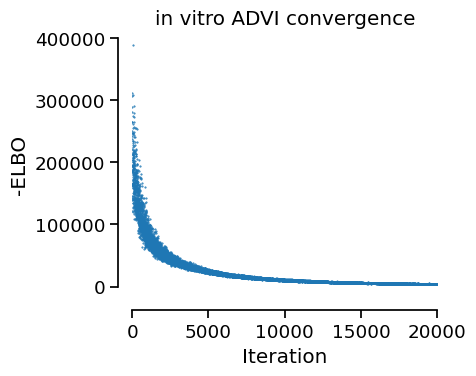

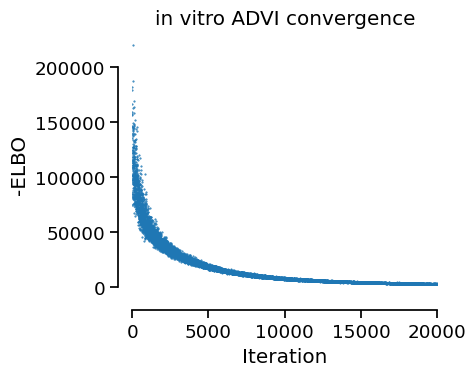

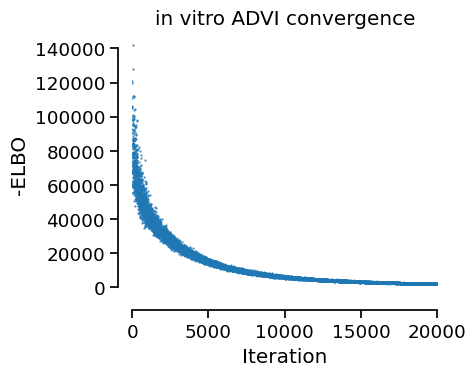

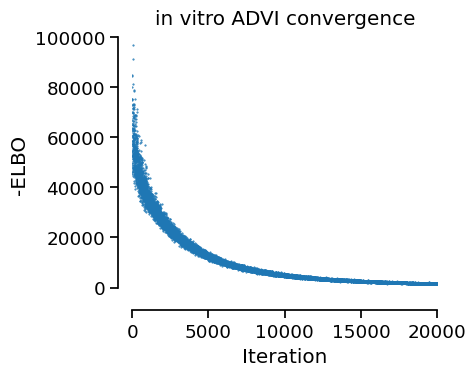

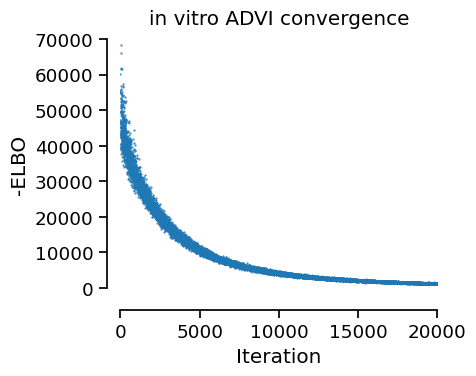

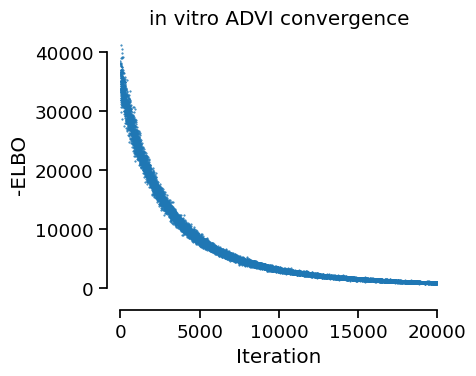

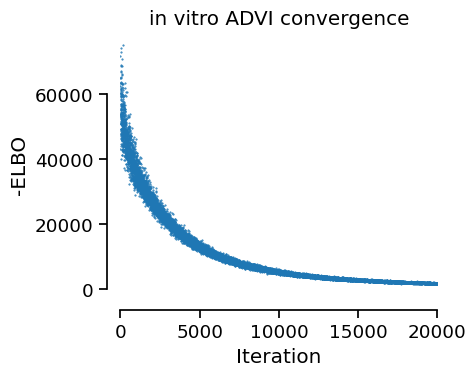

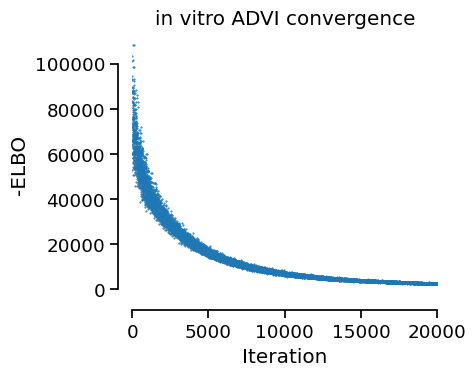

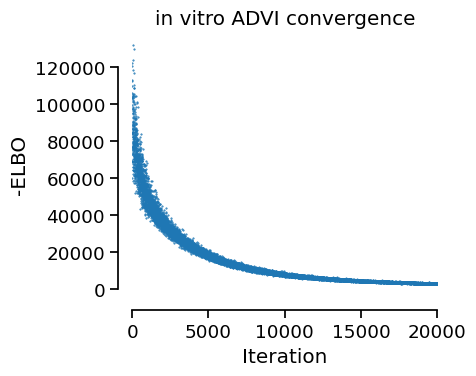

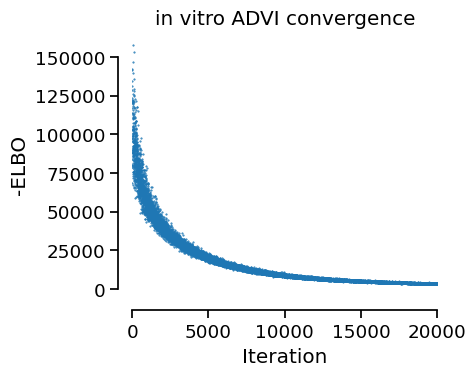

In [9]:
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)
trace05 = run_BayesInf(BMCA_obj05, n_samp=3)

trace15 = run_BayesInf(BMCA_obj15, n_samp=3)
trace3 = run_BayesInf(BMCA_obj3, n_samp=3)
trace5 = run_BayesInf(BMCA_obj5, n_samp=3)
trace7 = run_BayesInf(BMCA_obj7, n_samp=3)
trace100 = run_BayesInf(BMCA_obj100, n_samp=3)

### saving trace data

In [10]:
with gzip.open("../../../data/results/picklejar/topologyB-reg1_omitEnzymes_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
        
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [11]:
picklefolder = '../../../data/results/picklejar/'
with gzip.open(picklefolder + 'topologyB-reg1_omitEnzymes_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [12]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check 

In [13]:
med_Ex01_advi = util.get_az_mean(trace01)
med_Ex02_advi = util.get_az_mean(trace02)
med_Ex03_advi = util.get_az_mean(trace03)
med_Ex04_advi = util.get_az_mean(trace04)
med_Ex05_advi = util.get_az_mean(trace05)

med_Ex15_advi = util.get_az_mean(trace15)
med_Ex3_advi = util.get_az_mean(trace3)
med_Ex5_advi = util.get_az_mean(trace5)
med_Ex7_advi = util.get_az_mean(trace7)
med_Ex100_advi = util.get_az_mean(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [14]:
et01_0 = (trace01[0]['posterior']['e_t']).to_numpy().squeeze()
et01_1 = (trace01[1]['posterior']['e_t']).to_numpy().squeeze()
et01_2 = (trace01[2]['posterior']['e_t']).to_numpy().squeeze()
et01 = np.concatenate([et01_0, et01_1, et01_2])
med_et_advi_01 = np.median(et01, axis=0).transpose()

et02_0 = (trace02[0]['posterior']['e_t']).to_numpy().squeeze()
et02_1 = (trace02[1]['posterior']['e_t']).to_numpy().squeeze()
et02_2 = (trace02[2]['posterior']['e_t']).to_numpy().squeeze()
et02 = np.concatenate([et02_0, et02_1, et02_2])
med_et_advi_02 = np.median(et02, axis=0).transpose()

et03_0 = (trace03[0]['posterior']['e_t']).to_numpy().squeeze()
et03_1 = (trace03[1]['posterior']['e_t']).to_numpy().squeeze()
et03_2 = (trace03[2]['posterior']['e_t']).to_numpy().squeeze()
et03 = np.concatenate([et03_0, et03_1, et03_2])
med_et_advi_03 = np.median(et03, axis=0).transpose()

et04_0 = (trace04[0]['posterior']['e_t']).to_numpy().squeeze()
et04_1 = (trace04[1]['posterior']['e_t']).to_numpy().squeeze()
et04_2 = (trace04[2]['posterior']['e_t']).to_numpy().squeeze()
et04 = np.concatenate([et04_0, et04_1, et04_2])
med_et_advi_04 = np.median(et04, axis=0).transpose()

et05_0 = (trace05[0]['posterior']['e_t']).to_numpy().squeeze()
et05_1 = (trace05[1]['posterior']['e_t']).to_numpy().squeeze()
et05_2 = (trace05[2]['posterior']['e_t']).to_numpy().squeeze()
et05 = np.concatenate([et05_0, et05_1, et05_2])
med_et_advi_05 = np.median(et05, axis=0).transpose()

et15_0 = (trace15[0]['posterior']['e_t']).to_numpy().squeeze()
et15_1 = (trace15[1]['posterior']['e_t']).to_numpy().squeeze()
et15_2 = (trace15[2]['posterior']['e_t']).to_numpy().squeeze()
et15 = np.concatenate([et15_0, et15_1, et15_2])
med_et_advi_15 = np.median(et15, axis=0).transpose()

et3_0 = (trace3[0]['posterior']['e_t']).to_numpy().squeeze()
et3_1 = (trace3[1]['posterior']['e_t']).to_numpy().squeeze()
et3_2 = (trace3[2]['posterior']['e_t']).to_numpy().squeeze()
et3 = np.concatenate([et3_0, et3_1, et3_2])
med_et_advi_3 = np.median(et3, axis=0).transpose()

et5_0 = (trace5[0]['posterior']['e_t']).to_numpy().squeeze()
et5_1 = (trace5[1]['posterior']['e_t']).to_numpy().squeeze()
et5_2 = (trace5[2]['posterior']['e_t']).to_numpy().squeeze()
et5 = np.concatenate([et5_0, et5_1, et5_2])
med_et_advi_5 = np.median(et5, axis=0).transpose()

et7_0 = (trace7[0]['posterior']['e_t']).to_numpy().squeeze()
et7_1 = (trace7[1]['posterior']['e_t']).to_numpy().squeeze()
et7_2 = (trace7[2]['posterior']['e_t']).to_numpy().squeeze()
et7 = np.concatenate([et7_0, et7_1, et7_2])
med_et_advi_7 = np.median(et7, axis=0).transpose()

et100_0 = (trace100[0]['posterior']['e_t']).to_numpy().squeeze()
et100_1 = (trace100[1]['posterior']['e_t']).to_numpy().squeeze()
et100_2 = (trace100[2]['posterior']['e_t']).to_numpy().squeeze()
et100 = np.concatenate([et100_0, et100_1, et100_2])
med_et_advi_100 = np.median(et100, axis=0).transpose()


In [15]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                med_Ex01_advi, med_Ex02_advi, med_Ex03_advi, 
                               med_Ex04_advi, med_Ex05_advi,
                               med_Ex15_advi, med_Ex3_advi, med_Ex5_advi, 
                               med_Ex7_advi, med_Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-reg1_omitFluxes_elasticities.csv')

In [16]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

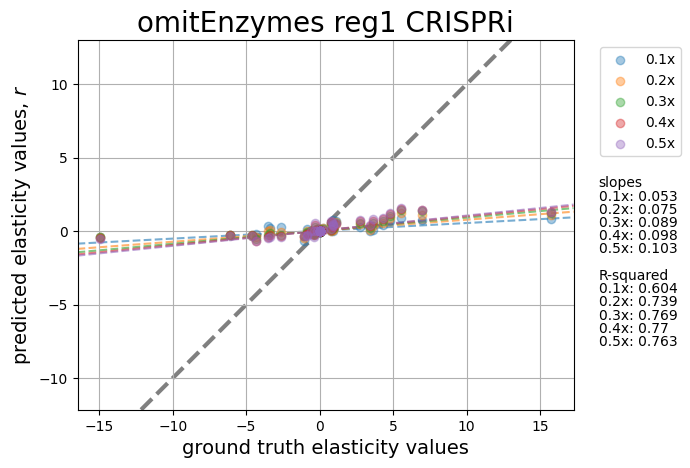

In [17]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('omitEnzymes reg1 CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 19
line_spacing = 0.9
slope_start = 3
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

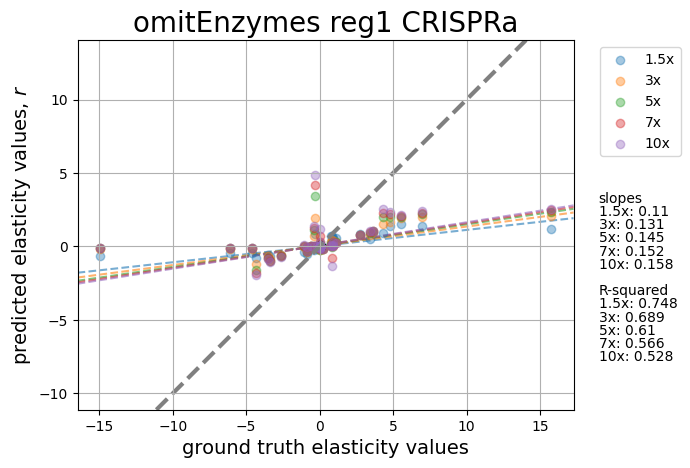

In [18]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('omitEnzymes reg1 CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 19
line_spacing = 0.9
slope_start = 3
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[5:]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+5]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[5:]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+5]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+5]), slope=e_slopes[i+5], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

## Calculating FCCs

In [19]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

In [20]:
Ex01_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex02_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj02)['prior']['Ex'])
Ex03_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex04_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj04)['prior']['Ex'])
Ex05_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

In [21]:
BMCA_obj01.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj02.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj03.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj04.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj05.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj15.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj3.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj5.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj7.en = pd.DataFrame(np.ones((20,19)))
BMCA_obj100.en = pd.DataFrame(np.ones((20,19)))


In [22]:
priorFCC01 = util.estimate_FCCs(BMCA_obj01, Ex01_prior.reshape((19,13)))
priorFCC02 = util.estimate_FCCs(BMCA_obj02, Ex02_prior.reshape((19,13)))
priorFCC03 = util.estimate_FCCs(BMCA_obj03, Ex03_prior.reshape((19,13)))
priorFCC04 = util.estimate_FCCs(BMCA_obj04, Ex04_prior.reshape((19,13)))
priorFCC05 = util.estimate_FCCs(BMCA_obj05, Ex05_prior.reshape((19,13)))

priorFCC15 = util.estimate_FCCs(BMCA_obj15, Ex15_prior.reshape((19,13)))
priorFCC3 = util.estimate_FCCs(BMCA_obj3, Ex3_prior.reshape((19,13)))
priorFCC5 = util.estimate_FCCs(BMCA_obj5, Ex5_prior.reshape((19,13)))
priorFCC7 = util.estimate_FCCs(BMCA_obj7, Ex7_prior.reshape((19,13)))
priorFCC100 = util.estimate_FCCs(BMCA_obj100, Ex100_prior.reshape((19,13)))


In [23]:
def estimate_CCs(BMCA_obj, Ex, med_et_advi):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(med_et_advi / BMCA_obj.vn)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(3000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(3000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(3000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC


In [24]:
postFCC01 = estimate_CCs(BMCA_obj01, med_Ex01_advi.reshape((19,13)), med_et_advi_01)
postFCC02 = estimate_CCs(BMCA_obj02, med_Ex02_advi.reshape((19,13)), med_et_advi_02)
postFCC03 = estimate_CCs(BMCA_obj03, med_Ex03_advi.reshape((19,13)), med_et_advi_03)
postFCC04 = estimate_CCs(BMCA_obj04, med_Ex04_advi.reshape((19,13)), med_et_advi_04)
postFCC05 = estimate_CCs(BMCA_obj05, med_Ex05_advi.reshape((19,13)), med_et_advi_05)

postFCC15 = estimate_CCs(BMCA_obj15, med_Ex15_advi.reshape((19,13)), med_et_advi_15)
postFCC3 = estimate_CCs(BMCA_obj3, med_Ex3_advi.reshape((19,13)), med_et_advi_3)
postFCC5 = estimate_CCs(BMCA_obj5, med_Ex5_advi.reshape((19,13)), med_et_advi_5)
postFCC7 = estimate_CCs(BMCA_obj7, med_Ex7_advi.reshape((19,13)), med_et_advi_7)
postFCC100 = estimate_CCs(BMCA_obj100, med_Ex100_advi.reshape((19,13)), med_et_advi_100)

In [25]:
prior_FCCs = [priorFCC01, priorFCC02, priorFCC03, priorFCC04, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


## Evaluating FCC ranking

In [26]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v19']

### via Spearman rank coefficients

In [27]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [28]:
pt_labels = [i+'-prior' for i in pt_labels] + [i+'-post' for i in pt_labels]

In [29]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x-prior,0.314757,0.203314,-0.261257,0.700116
0.2x-prior,0.259030,0.299305,-0.290040,0.683020
0.3x-prior,0.248710,0.319645,-0.316148,0.692477
0.4x-prior,0.259030,0.299305,-0.273144,0.702753
0.5x-prior,0.246646,0.323809,-0.367364,0.668284
1.5x-prior,0.271414,0.275952,-0.291712,0.689458
3x-prior,0.238390,0.340780,-0.307354,0.703864
5x-prior,0.236326,0.345101,-0.312462,0.727784
7x-prior,0.236326,0.345101,-0.295301,0.737841
10x-prior,0.232198,0.353838,-0.323031,0.709005


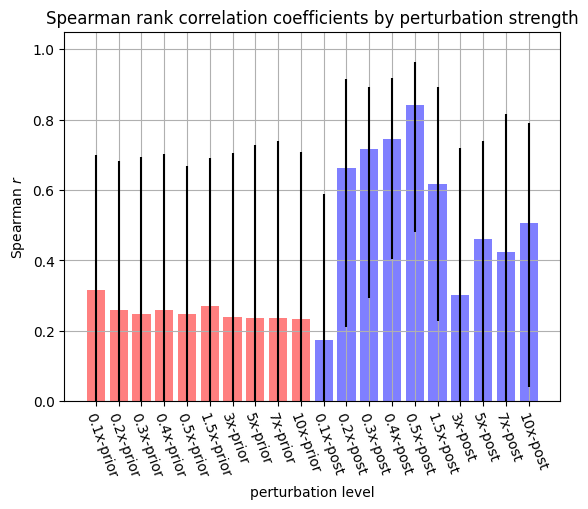

In [30]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']*10 + ['b']*10)
plt.grid()

for i, val in enumerate(spearman_df['r']):
    if val < 0: 
        c ='gray'
    else: 
        c='k'
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color=c)

for i, val in enumerate(spearman_df['r']):
    if val < 0: 
        plt.annotate(round(val, 2), (pt_labels[i], 0.02), size=8, ha='center', rotation=30,rotation_mode="anchor")

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

_=plt.xticks(rotation=-70,ha='left',rotation_mode="anchor")

In [31]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyB_reg1_omitEnzymes_spr.csv')

### evaluating top 10 rankings

In [32]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v19') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v19')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,...,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
v19,,,,,,,,,,,,,,,,,,,,,
1.0,v18,v18,v18,v18,v18,v18,v18,v18,v18,v18,...,v7,v1,v18,v18,v1,v1,v1,v7,v7,v4
2.0,v1,v8,v8,v8,v14,v14,v15,v15,v15,v15,...,v6,v5,v5,v1,v18,v7,v4,v4,v4,v9
3.0,v7,v14,v14,v14,v8,v8,v14,v16,v16,v16,...,v3,v7,v14,v14,v7,v3,v3,v5,v5,v7
4.0,v14,v17,v17,v16,v16,v16,v16,v17,v17,v17,...,v2,v18,v1,v5,v14,v18,v5,v1,v9,v1
5.0,v5,v16,v16,v17,v17,v17,v17,v14,v14,v14,...,v5,v6,v6,v8,v3,v9,v7,v3,v3,v3
6.0,v4,v13,v13,v13,v13,v15,v8,v5,v5,v5,...,v8,v14,v8,v6,v8,v2,v2,v9,v1,v5
7.0,v9,v4,v4,v15,v15,v13,v5,v1,v1,v1,...,v18,v2,v9,v9,v9,v12,v9,v2,v2,v2
8.0,v3,v1,v15,v4,v4,v4,v4,v4,v4,v4,...,v11,v4,v13,v7,v5,v14,v6,v6,v6,v12
9.0,v8,v7,v1,v1,v1,v1,v1,v6,v6,v6,...,v1,v8,v3,v13,v6,v10,v12,v18,v12,v6


In [33]:
q.to_csv('../../../data/results/rankings/topologyB-reg1_omitEnzymes_rankings.csv')
rank_df = pd.read_csv('../../../data/results/rankings/topologyB-reg1_omitEnzymes_rankings.csv')

In [34]:
topTen_df = rank_df[rank_df['v19'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,10x-prior,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
0,6,6,6,6,6,7,6,6,6,6,7,8,8,8,8,7,6,8,7,6


In [35]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([11, 12, 14, 16], dtype='int64')
Int64Index([11, 12, 14, 16], dtype='int64')
Int64Index([11, 12, 14, 16], dtype='int64')
Int64Index([11, 12, 14, 16], dtype='int64')
Int64Index([11, 12, 14, 16], dtype='int64')
Int64Index([12, 14, 16], dtype='int64')
Int64Index([12, 13, 14, 16], dtype='int64')
Int64Index([12, 13, 14, 16], dtype='int64')
Int64Index([12, 13, 14, 16], dtype='int64')
Int64Index([12, 13, 14, 16], dtype='int64')
Int64Index([13, 15, 17], dtype='int64')
Int64Index([13, 17], dtype='int64')
Int64Index([11, 13], dtype='int64')
Int64Index([11, 13], dtype='int64')
Int64Index([11, 13], dtype='int64')
Int64Index([10, 15, 17], dtype='int64')
Int64Index([10, 13, 15, 17], dtype='int64')
Int64Index([13, 17], dtype='int64')
Int64Index([10, 13, 17], dtype='int64')
Int64Index([10, 12, 13, 17], dtype='int64')
